<img src='https://raw.githubusercontent.com/Deci-AI/super-gradients/master/documentation/assets/SG_img/SG%20-%20Horizontal%20Glow.png'>

# Quantization Aware Training YoloNAS on Custom Dataset



**Background**: Our research team developed a new deep learning architecture that competes with YOLOv8 using our efficient AutoNAC algorithm.
The new model, named YoloNAS, incorporates quantization-aware RepVGG blocks into the model architecture to ensure compatibility with Post-Training Quantization, making it more flexible and usable for different hardware configurations.


In this tutorial, we will demonstrate how to fine-tune the small variant of the YoloNAS, YoloNAS_S on a custom dataset: the [RF Soccer Players Dataset](https://universe.roboflow.com/roboflow-100/soccer-players-5fuqs) .

0. Installations and dataset setup.
1. Initialize train and validation dataloaders.
2. Define training hyper-parameters.
3. Instantiate a pre-trained YoloNAS_S model and launch training.
4. Run prediction on a real world input.
5. Load the best checkpoint from 3., perform post-training quantization and quantization-aware training.


Prerequisites:
- QAT/PTQ tutorials: [classification notebook](https://github.com/Deci-AI/super-gradients/blob/master/tutorials/PTQ_and_QAT_for_classification.ipynb), [Thorough tutorial](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/ptq_qat.md)
- Training object detection models in SG: [Transfer learning notebook](https://bit.ly/3SkMohx).

It is also recommended to see the QAT/PTQ [tutorial](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj125-xvIv_AhVZhP0HHWQnCZYQFnoECBYQAQ&url=https%3A%2F%2Fwww.nvidia.com%2Fen-us%2Fon-demand%2Fsession%2Fgtcspring21-s31653%2F&usg=AOvVaw1i_93iFvK5HJDm_5-SXyMN) from Nvidia.

In [1]:
!pip install -qq super-gradients == 3.4.0 pytorch-quantization == 2.1.2 datasets[vision]  --extra-index-url https: // pypi.ngc.nvidia.com

ERROR: Invalid requirement: '=='


## Step 0: Dataset Setup

In [2]:
from datasets import load_dataset

dataset = load_dataset("cppe-5")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 29
    })
})

In [4]:
dataset["train"].features

{'image_id': Value(dtype='int64', id=None),
 'image': Image(decode=True, id=None),
 'width': Value(dtype='int32', id=None),
 'height': Value(dtype='int32', id=None),
 'objects': Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask'], id=None)}, length=-1, id=None)}

In [5]:
CLASS_NAMES = dataset["train"].features["objects"].feature["category"].names
NUM_CLASSES = len(CLASS_NAMES)

In [6]:
from tqdm import tqdm
import cv2
import numpy as np
import json
import os


def convert_hf_to_coco(dataset_split, output_images_directory, output_annotation_json):
    class_names = dataset["train"].features["objects"].feature["category"].names

    coco_annotation = {
        "images": [],
        "annotations": [],
        "categories": [{"supercategory": name, "name": name, "id": category_id} for category_id, name in enumerate(class_names)],
    }

    os.makedirs(output_images_directory, exist_ok=True)

    annotation_id = 1

    for sample in tqdm(dataset_split):
        image_id = sample["image_id"]
        image = np.array(sample["image"])

        objects = sample["objects"]
        areas = objects["area"]
        bboxes = objects["bbox"]  # XYWH
        category_ids = objects["category"]

        for object_area, object_bbox, object_category in zip(areas, bboxes, category_ids):
            coco_annotation["annotations"].append(
                {
                    "id": annotation_id,
                    "category_id": object_category,
                    "area": float(object_area),
                    "iscrowd": 0,
                    "image_id": image_id,
                    "bbox": list(map(int, object_bbox)),
                }
            )
            annotation_id += 1

        filename = f"{image_id}.jpg"
        output_image_path = os.path.join(output_images_directory, filename)
        cv2.imwrite(output_image_path, image[..., ::-1])  # RGB to BGR

        coco_annotation["images"].append({"file_name": filename, "height": image.shape[0], "width": image.shape[1], "id": image_id})

    with open(output_annotation_json, "w") as f:
        json.dump(coco_annotation, f)


convert_hf_to_coco(dataset["train"], "cppe-5-coco/images/train", "cppe-5-coco/train_annotations.coco.json")
convert_hf_to_coco(dataset["test"], "cppe-5-coco/images/valid", "cppe-5-coco/valid_annotations.coco.json")

100%|██████████| 29/29 [00:00<00:00, 33.03it/s]


# Installations

## Step 1: Initialize train and validation dataloaders.

Next, we instantiate torch DataLoader objects, one for training and one for validation which will be used for our our regular (non QAT training).

Notice how we use SG's dataloaders.get in order to initialize the data loaders, as it comes in handy when wanting to simplify the initialization of components such as the Sampler. We also use the "min_samples" option to truncate the dataset since it is a relatively small.


In [7]:
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.transforms.transforms import (
    DetectionMosaic,
    DetectionRandomAffine,
    DetectionHSV,
    DetectionHorizontalFlip,
    DetectionPaddedRescale,
    DetectionStandardize,
    DetectionTargetsFormatTransform,
)
from super_gradients.training.utils.collate_fn import DetectionCollateFN
from super_gradients.training import dataloaders
from super_gradients.training.datasets.datasets_utils import worker_init_reset_seed

train_dataset_params = dict(
    data_dir="cppe-5-coco",
    images_dir="images/train",
    json_annotation_file="train_annotations.coco.json",
    input_dim=(640, 640),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionMosaic(prob=1.0, input_dim=(640, 640)),
        DetectionRandomAffine(degrees=0.0, scales=(0.5, 1.5), shear=0.0, target_size=(640, 640), filter_box_candidates=False, border_value=128),
        DetectionHSV(prob=1.0, hgain=5, vgain=30, sgain=30),
        DetectionHorizontalFlip(prob=0.5),
        DetectionPaddedRescale(input_dim=(640, 640), max_targets=300),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(640, 640), output_format="LABEL_CXCYWH"),
    ],
)

valid_dataset_params = dict(
    data_dir="cppe-5-coco",
    images_dir="images/valid",
    json_annotation_file="valid_annotations.coco.json",
    input_dim=(640, 640),
    ignore_empty_annotations=False,
    with_crowd=False,
    all_classes_list=CLASS_NAMES,
    transforms=[
        DetectionPaddedRescale(input_dim=(640, 640), max_targets=300),
        DetectionStandardize(max_value=255),
        DetectionTargetsFormatTransform(input_dim=(640, 640), output_format="LABEL_CXCYWH"),
    ],
)

trainset = COCOFormatDetectionDataset(**train_dataset_params)
valset = COCOFormatDetectionDataset(**valid_dataset_params)

The console stream is logged into C:\Users\ekhve\sg_logs\console.log


[2023-11-10 11:27:43] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-11-10 11:27:45] WARNING - redirects.py - NOTE: Redirects are currently not supported in Windows or MacOs.
W1110 11:27:45.737287  4232 redirects.py:27] NOTE: Redirects are currently not supported in Windows or MacOs.
[2023-11-10 11:27:50] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.
W1110 11:27:50.275378  4232 env_sanity_check.py:31] Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.
[2023-11-10 11:27:50] WARNING - env_sanity_check.py - Failed to verify installed packages: data-gradients==0.2.2 does not satisfy requirement data-gradients>=0.3.0
W1110 11:27:50.287667  4232 env_sanity_check.py:110] Failed to verify installed packages: data-gradients==0.2.2 does no

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


Indexing dataset annotations:  64%|██████▎   | 637/1000 [00:00<00:00, 3169.03it/s]

In [8]:
from torch.utils.data import DataLoader

train_dataloader_params = {
    "shuffle": True,
    "batch_size": 16,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "worker_init_fn": worker_init_reset_seed,
    "num_workers": 4,
    "persistent_workers": True,
}

val_dataloader_params = {
    "shuffle": False,
    "batch_size": 32,
    "drop_last": False,
    "pin_memory": True,
    "collate_fn": DetectionCollateFN(),
    "worker_init_fn": worker_init_reset_seed,
    "num_workers": 4,
    "persistent_workers": True,
}

train_loader = DataLoader(trainset, **train_dataloader_params)
valid_loader = DataLoader(valset, **val_dataloader_params)

#Step 2: Defining training hyperparameters

In [9]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    "warmup_initial_lr": 1e-6,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "zero_weight_decay_on_bias_and_bn": True,
    "lr_warmup_epochs": 3,
    "warmup_mode": "LinearEpochLRWarmup",
    "optimizer_params": {"weight_decay": 0.0001},
    "ema": True,
    "ema_params": {"beta": 25, "decay_type": "exp"},
    "max_epochs": 30,
    "mixed_precision": True,
    "loss": PPYoloELoss(use_static_assigner=False, num_classes=NUM_CLASSES, reg_max=16),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=NUM_CLASSES,
            normalize_targets=True,
            include_classwise_ap=True,
            class_names=CLASS_NAMES,
            post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300, nms_threshold=0.7),
        )
    ],
    "metric_to_watch": "mAP@0.50",
}

# Step 3: Instantiate a pre-trained YoloNAS_S and launch training

We instantiate a YoloNAS_S model, pre-trained on the [COCO detection dataset](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj23aGooYv_AhUTh_0HHblrAYsQFnoECAkQAQ&url=https%3A%2F%2Fcocodataset.org%2F&usg=AOvVaw2uf7n84Wuno9qgkHK-zOGp).
Notice we specify num_classes which is different from the 80 classes of COCO, which results in replacing the classification branch of our model's head.

In [10]:
from super_gradients.training import Trainer
from super_gradients.common.object_names import Models
from super_gradients.training import models

trainer = Trainer(experiment_name="yolo_nas_s_cppe-5", ckpt_root_dir="experiments")
model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, pretrained_weights="coco")
trainer.train(model=model, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader)

Indexing dataset annotations: 100%|██████████| 29/29 [00:00<00:00, 2226.19it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


[2023-11-10 11:27:51] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
W1110 11:27:51.419545  4232 sg_trainer.py:1195] Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.


The console stream is now moved to experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019/console_Nov10_11_27_51.txt


[2023-11-10 11:27:52] INFO - sg_trainer.py - Using EMA with params {'beta': 25, 'decay_type': 'exp'}
[2023-11-10 11:27:52] WARNING - ema.py - Parameter `decay` is not specified for EMA params. Please specify `decay` parameter explicitly in your config:
ema: True
ema_params: 
  decay: 0.9999
  decay_type: exp
  beta: 15
Will default to decay: 0.9999
In the next major release of SG this warning will become an error.
[2023-11-10 11:28:35] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            1000       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.6258
│   ├── Ppyoloeloss/loss_iou = 0.5111
│   ├── Ppyoloeloss/loss_dfl = 0.597
│   └── Ppyoloeloss/loss = 3.7339
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.6522
    ├── Ppyoloeloss/loss_iou = 0.5183
    ├── Ppyoloeloss/loss_dfl = 0.605
    ├── Ppyoloeloss/loss = 3.7756
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0757
    ├── F1@0.50 = 0.0
    ├── Ap@0.50_coverall = 0.376
    ├── Ap@0.50_face_shield = 0.0009
    ├── Ap@0.50_gloves = 0.0
    ├── Ap@0.50_goggles = 0.0014
    └── Ap@0.50_mask = 0.0



Validating epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]
[2023-11-10 11:29:57] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth
[2023-11-10 11:29:57] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.627301037311554


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1486
│   │   ├── Epoch N-1      = 2.6258 (↘ -1.4772)
│   │   └── Best until now = 2.6258 (↘ -1.4772)
│   ├── Ppyoloeloss/loss_iou = 0.5039
│   │   ├── Epoch N-1      = 0.5111 (↘ -0.0072)
│   │   └── Best until now = 0.5111 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_dfl = 0.5222
│   │   ├── Epoch N-1      = 0.597  (↘ -0.0749)
│   │   └── Best until now = 0.597  (↘ -0.0749)
│   └── Ppyoloeloss/loss = 2.1746
│       ├── Epoch N-1      = 3.7339 (↘ -1.5593)
│       └── Best until now = 3.7339 (↘ -1.5593)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9287
    │   ├── Epoch N-1      = 2.6522 (↘ -1.7235)
    │   └── Best until now = 2.6522 (↘ -1.7235)
    ├── Ppyoloeloss/loss_iou = 0.4304
    │   ├── Epoch N-1      = 0.5183 (↘ -0.088)
    │   └── Best until now = 0.5183 (↘ -0.088)
    ├── Ppyoloeloss/loss_dfl = 0.4587
    │   ├── Epoch N-1      = 0.605  (↘ -0.1463)
    │   └── Best until now = 0.605  (↘ -0.1463)
    ├── Ppyoloeloss/loss

Validating epoch 2: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]
[2023-11-10 11:30:28] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth
[2023-11-10 11:30:28] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6567850708961487


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9168
│   │   ├── Epoch N-1      = 1.1486 (↘ -0.2318)
│   │   └── Best until now = 1.1486 (↘ -0.2318)
│   ├── Ppyoloeloss/loss_iou = 0.5039
│   │   ├── Epoch N-1      = 0.5039 (↗ 0.0)
│   │   └── Best until now = 0.5039 (↗ 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.522
│   │   ├── Epoch N-1      = 0.5222 (↘ -0.0002)
│   │   └── Best until now = 0.5222 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 1.9427
│       ├── Epoch N-1      = 2.1746 (↘ -0.232)
│       └── Best until now = 2.1746 (↘ -0.232)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0929
    │   ├── Epoch N-1      = 0.9287 (↗ 0.1642)
    │   └── Best until now = 0.9287 (↗ 0.1642)
    ├── Ppyoloeloss/loss_iou = 0.461
    │   ├── Epoch N-1      = 0.4304 (↗ 0.0306)
    │   └── Best until now = 0.4304 (↗ 0.0306)
    ├── Ppyoloeloss/loss_dfl = 0.486
    │   ├── Epoch N-1      = 0.4587 (↗ 0.0273)
    │   └── Best until now = 0.4587 (↗ 0.0273)
    ├── Ppyoloeloss/loss = 2.0399
    │  

Validating epoch 3: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]
[2023-11-10 11:31:01] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth
[2023-11-10 11:31:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6720665693283081


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9096
│   │   ├── Epoch N-1      = 0.9168 (↘ -0.0072)
│   │   └── Best until now = 0.9168 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.5055
│   │   ├── Epoch N-1      = 0.5039 (↗ 0.0016)
│   │   └── Best until now = 0.5039 (↗ 0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.5266
│   │   ├── Epoch N-1      = 0.522  (↗ 0.0046)
│   │   └── Best until now = 0.522  (↗ 0.0046)
│   └── Ppyoloeloss/loss = 1.9417
│       ├── Epoch N-1      = 1.9427 (↘ -0.001)
│       └── Best until now = 1.9427 (↘ -0.001)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9621
    │   ├── Epoch N-1      = 1.0929 (↘ -0.1308)
    │   └── Best until now = 0.9287 (↗ 0.0334)
    ├── Ppyoloeloss/loss_iou = 0.4882
    │   ├── Epoch N-1      = 0.461  (↗ 0.0273)
    │   └── Best until now = 0.4304 (↗ 0.0579)
    ├── Ppyoloeloss/loss_dfl = 0.5117
    │   ├── Epoch N-1      = 0.486  (↗ 0.0256)
    │   └── Best until now = 0.4587 (↗ 0.053)
    ├── Ppyoloeloss/loss = 1.962
 

Validating epoch 4: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]
[2023-11-10 11:31:34] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth
[2023-11-10 11:31:34] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8084414601325989


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8857
│   │   ├── Epoch N-1      = 0.9096 (↘ -0.0239)
│   │   └── Best until now = 0.9096 (↘ -0.0239)
│   ├── Ppyoloeloss/loss_iou = 0.5072
│   │   ├── Epoch N-1      = 0.5055 (↗ 0.0017)
│   │   └── Best until now = 0.5039 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.5263
│   │   ├── Epoch N-1      = 0.5266 (↘ -0.0003)
│   │   └── Best until now = 0.522  (↗ 0.0043)
│   └── Ppyoloeloss/loss = 1.9192
│       ├── Epoch N-1      = 1.9417 (↘ -0.0225)
│       └── Best until now = 1.9417 (↘ -0.0225)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8149
    │   ├── Epoch N-1      = 0.9621 (↘ -0.1473)
    │   └── Best until now = 0.9287 (↘ -0.1138)
    ├── Ppyoloeloss/loss_iou = 0.4155
    │   ├── Epoch N-1      = 0.4882 (↘ -0.0728)
    │   └── Best until now = 0.4304 (↘ -0.0149)
    ├── Ppyoloeloss/loss_dfl = 0.4545
    │   ├── Epoch N-1      = 0.5117 (↘ -0.0571)
    │   └── Best until now = 0.4587 (↘ -0.0041)
    ├── Ppyoloeloss/loss 

Validating epoch 5: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
[2023-11-10 11:32:06] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth
[2023-11-10 11:32:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.888201892375946


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8617
│   │   ├── Epoch N-1      = 0.8857 (↘ -0.024)
│   │   └── Best until now = 0.8857 (↘ -0.024)
│   ├── Ppyoloeloss/loss_iou = 0.4954
│   │   ├── Epoch N-1      = 0.5072 (↘ -0.0118)
│   │   └── Best until now = 0.5039 (↘ -0.0084)
│   ├── Ppyoloeloss/loss_dfl = 0.5157
│   │   ├── Epoch N-1      = 0.5263 (↘ -0.0106)
│   │   └── Best until now = 0.522  (↘ -0.0063)
│   └── Ppyoloeloss/loss = 1.8729
│       ├── Epoch N-1      = 1.9192 (↘ -0.0463)
│       └── Best until now = 1.9192 (↘ -0.0463)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7346
    │   ├── Epoch N-1      = 0.8149 (↘ -0.0803)
    │   └── Best until now = 0.8149 (↘ -0.0803)
    ├── Ppyoloeloss/loss_iou = 0.3835
    │   ├── Epoch N-1      = 0.4155 (↘ -0.032)
    │   └── Best until now = 0.4155 (↘ -0.032)
    ├── Ppyoloeloss/loss_dfl = 0.426
    │   ├── Epoch N-1      = 0.4545 (↘ -0.0285)
    │   └── Best until now = 0.4545 (↘ -0.0285)
    ├── Ppyoloeloss/loss = 

Validating epoch 6: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]
[2023-11-10 11:32:39] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth
[2023-11-10 11:32:39] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9028568267822266


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8519
│   │   ├── Epoch N-1      = 0.8617 (↘ -0.0098)
│   │   └── Best until now = 0.8617 (↘ -0.0098)
│   ├── Ppyoloeloss/loss_iou = 0.4871
│   │   ├── Epoch N-1      = 0.4954 (↘ -0.0083)
│   │   └── Best until now = 0.4954 (↘ -0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.5134
│   │   ├── Epoch N-1      = 0.5157 (↘ -0.0024)
│   │   └── Best until now = 0.5157 (↘ -0.0024)
│   └── Ppyoloeloss/loss = 1.8524
│       ├── Epoch N-1      = 1.8729 (↘ -0.0205)
│       └── Best until now = 1.8729 (↘ -0.0205)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7257
    │   ├── Epoch N-1      = 0.7346 (↘ -0.0089)
    │   └── Best until now = 0.7346 (↘ -0.0089)
    ├── Ppyoloeloss/loss_iou = 0.3834
    │   ├── Epoch N-1      = 0.3835 (↘ -1e-04)
    │   └── Best until now = 0.3835 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.4283
    │   ├── Epoch N-1      = 0.426  (↗ 0.0023)
    │   └── Best until now = 0.426  (↗ 0.0023)
    ├── Ppyoloeloss/loss =

Validating epoch 7: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
[2023-11-10 11:33:13] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth
[2023-11-10 11:33:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9106253385543823


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8466
│   │   ├── Epoch N-1      = 0.8519 (↘ -0.0053)
│   │   └── Best until now = 0.8519 (↘ -0.0053)
│   ├── Ppyoloeloss/loss_iou = 0.4747
│   │   ├── Epoch N-1      = 0.4871 (↘ -0.0125)
│   │   └── Best until now = 0.4871 (↘ -0.0125)
│   ├── Ppyoloeloss/loss_dfl = 0.5025
│   │   ├── Epoch N-1      = 0.5134 (↘ -0.0109)
│   │   └── Best until now = 0.5134 (↘ -0.0109)
│   └── Ppyoloeloss/loss = 1.8238
│       ├── Epoch N-1      = 1.8524 (↘ -0.0286)
│       └── Best until now = 1.8524 (↘ -0.0286)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7108
    │   ├── Epoch N-1      = 0.7257 (↘ -0.0149)
    │   └── Best until now = 0.7257 (↘ -0.0149)
    ├── Ppyoloeloss/loss_iou = 0.3821
    │   ├── Epoch N-1      = 0.3834 (↘ -0.0012)
    │   └── Best until now = 0.3834 (↘ -0.0012)
    ├── Ppyoloeloss/loss_dfl = 0.4272
    │   ├── Epoch N-1      = 0.4283 (↘ -0.0011)
    │   └── Best until now = 0.426  (↗ 0.0012)
    ├── Ppyoloeloss/los

Validating epoch 8: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]
[2023-11-10 11:33:49] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth
[2023-11-10 11:33:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9132579565048218


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8483
│   │   ├── Epoch N-1      = 0.8466 (↗ 0.0017)
│   │   └── Best until now = 0.8466 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.4815
│   │   ├── Epoch N-1      = 0.4747 (↗ 0.0068)
│   │   └── Best until now = 0.4747 (↗ 0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.5067
│   │   ├── Epoch N-1      = 0.5025 (↗ 0.0042)
│   │   └── Best until now = 0.5025 (↗ 0.0042)
│   └── Ppyoloeloss/loss = 1.8365
│       ├── Epoch N-1      = 1.8238 (↗ 0.0127)
│       └── Best until now = 1.8238 (↗ 0.0127)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7059
    │   ├── Epoch N-1      = 0.7108 (↘ -0.0049)
    │   └── Best until now = 0.7108 (↘ -0.0049)
    ├── Ppyoloeloss/loss_iou = 0.3791
    │   ├── Epoch N-1      = 0.3821 (↘ -0.003)
    │   └── Best until now = 0.3821 (↘ -0.003)
    ├── Ppyoloeloss/loss_dfl = 0.4252
    │   ├── Epoch N-1      = 0.4272 (↘ -0.0021)
    │   └── Best until now = 0.426  (↘ -0.0009)
    ├── Ppyoloeloss/loss = 1.510

Validating epoch 9: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8333
│   │   ├── Epoch N-1      = 0.8483 (↘ -0.015)
│   │   └── Best until now = 0.8466 (↘ -0.0133)
│   ├── Ppyoloeloss/loss_iou = 0.479
│   │   ├── Epoch N-1      = 0.4815 (↘ -0.0025)
│   │   └── Best until now = 0.4747 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.5022
│   │   ├── Epoch N-1      = 0.5067 (↘ -0.0046)
│   │   └── Best until now = 0.5025 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 1.8144
│       ├── Epoch N-1      = 1.8365 (↘ -0.0221)
│       └── Best until now = 1.8238 (↘ -0.0094)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7048
    │   ├── Epoch N-1      = 0.7059 (↘ -0.0012)
    │   └── Best until now = 0.7059 (↘ -0.0012)
    ├── Ppyoloeloss/loss_iou = 0.3781
    │   ├── Epoch N-1      = 0.3791 (↘ -0.001)
    │   └── Best until now = 0.3791 (↘ -0.001)
    ├── Ppyoloeloss/loss_dfl = 0.4246
    │   ├── Epoch N-1      = 0.4252 (↘ -0.0006)
    │   └── Best until now = 0.4252 (↘ -0.0006)
    ├── Ppyoloeloss/loss = 

Validating epoch 10: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8291
│   │   ├── Epoch N-1      = 0.8333 (↘ -0.0042)
│   │   └── Best until now = 0.8333 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.4761
│   │   ├── Epoch N-1      = 0.479  (↘ -0.0029)
│   │   └── Best until now = 0.4747 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.5046
│   │   ├── Epoch N-1      = 0.5022 (↗ 0.0025)
│   │   └── Best until now = 0.5022 (↗ 0.0025)
│   └── Ppyoloeloss/loss = 1.8098
│       ├── Epoch N-1      = 1.8144 (↘ -0.0046)
│       └── Best until now = 1.8144 (↘ -0.0046)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7063
    │   ├── Epoch N-1      = 0.7048 (↗ 0.0015)
    │   └── Best until now = 0.7048 (↗ 0.0015)
    ├── Ppyoloeloss/loss_iou = 0.3784
    │   ├── Epoch N-1      = 0.3781 (↗ 0.0004)
    │   └── Best until now = 0.3781 (↗ 0.0004)
    ├── Ppyoloeloss/loss_dfl = 0.4247
    │   ├── Epoch N-1      = 0.4246 (↗ 1e-04)
    │   └── Best until now = 0.4246 (↗ 1e-04)
    ├── Ppyoloeloss/loss = 1.509

Validating epoch 11: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8226
│   │   ├── Epoch N-1      = 0.8291 (↘ -0.0066)
│   │   └── Best until now = 0.8291 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.4651
│   │   ├── Epoch N-1      = 0.4761 (↘ -0.0109)
│   │   └── Best until now = 0.4747 (↘ -0.0095)
│   ├── Ppyoloeloss/loss_dfl = 0.4946
│   │   ├── Epoch N-1      = 0.5046 (↘ -0.01)
│   │   └── Best until now = 0.5022 (↘ -0.0076)
│   └── Ppyoloeloss/loss = 1.7823
│       ├── Epoch N-1      = 1.8098 (↘ -0.0276)
│       └── Best until now = 1.8098 (↘ -0.0276)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7067
    │   ├── Epoch N-1      = 0.7063 (↗ 0.0004)
    │   └── Best until now = 0.7048 (↗ 0.0019)
    ├── Ppyoloeloss/loss_iou = 0.3783
    │   ├── Epoch N-1      = 0.3784 (↘ -0.0002)
    │   └── Best until now = 0.3781 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.4247
    │   ├── Epoch N-1      = 0.4247 (↘ -0.0)
    │   └── Best until now = 0.4246 (↗ 1e-04)
    ├── Ppyoloeloss/loss = 1.50

Validating epoch 12: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8085
│   │   ├── Epoch N-1      = 0.8226 (↘ -0.0141)
│   │   └── Best until now = 0.8226 (↘ -0.0141)
│   ├── Ppyoloeloss/loss_iou = 0.4596
│   │   ├── Epoch N-1      = 0.4651 (↘ -0.0055)
│   │   └── Best until now = 0.4651 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_dfl = 0.4915
│   │   ├── Epoch N-1      = 0.4946 (↘ -0.0031)
│   │   └── Best until now = 0.4946 (↘ -0.0031)
│   └── Ppyoloeloss/loss = 1.7596
│       ├── Epoch N-1      = 1.7823 (↘ -0.0227)
│       └── Best until now = 1.7823 (↘ -0.0227)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7062
    │   ├── Epoch N-1      = 0.7067 (↘ -0.0005)
    │   └── Best until now = 0.7048 (↗ 0.0014)
    ├── Ppyoloeloss/loss_iou = 0.3783
    │   ├── Epoch N-1      = 0.3783 (↗ 1e-04)
    │   └── Best until now = 0.3781 (↗ 0.0003)
    ├── Ppyoloeloss/loss_dfl = 0.4245
    │   ├── Epoch N-1      = 0.4247 (↘ -0.0002)
    │   └── Best until now = 0.4246 (↘ -1e-04)
    ├── Ppyoloeloss/loss =

Validating epoch 13: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7967
│   │   ├── Epoch N-1      = 0.8085 (↘ -0.0117)
│   │   └── Best until now = 0.8085 (↘ -0.0117)
│   ├── Ppyoloeloss/loss_iou = 0.4562
│   │   ├── Epoch N-1      = 0.4596 (↘ -0.0034)
│   │   └── Best until now = 0.4596 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.4875
│   │   ├── Epoch N-1      = 0.4915 (↘ -0.004)
│   │   └── Best until now = 0.4915 (↘ -0.004)
│   └── Ppyoloeloss/loss = 1.7405
│       ├── Epoch N-1      = 1.7596 (↘ -0.0191)
│       └── Best until now = 1.7596 (↘ -0.0191)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7063
    │   ├── Epoch N-1      = 0.7062 (↗ 1e-04)
    │   └── Best until now = 0.7048 (↗ 0.0015)
    ├── Ppyoloeloss/loss_iou = 0.3783
    │   ├── Epoch N-1      = 0.3783 (↘ -1e-04)
    │   └── Best until now = 0.3781 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.4245
    │   ├── Epoch N-1      = 0.4245 (↘ -0.0)
    │   └── Best until now = 0.4245 (↘ -0.0)
    ├── Ppyoloeloss/loss = 1.509
 

Validating epoch 14: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8003
│   │   ├── Epoch N-1      = 0.7967 (↗ 0.0036)
│   │   └── Best until now = 0.7967 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.45
│   │   ├── Epoch N-1      = 0.4562 (↘ -0.0063)
│   │   └── Best until now = 0.4562 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.4849
│   │   ├── Epoch N-1      = 0.4875 (↘ -0.0026)
│   │   └── Best until now = 0.4875 (↘ -0.0026)
│   └── Ppyoloeloss/loss = 1.7351
│       ├── Epoch N-1      = 1.7405 (↘ -0.0053)
│       └── Best until now = 1.7405 (↘ -0.0053)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7056
    │   ├── Epoch N-1      = 0.7063 (↘ -0.0007)
    │   └── Best until now = 0.7048 (↗ 0.0008)
    ├── Ppyoloeloss/loss_iou = 0.3782
    │   ├── Epoch N-1      = 0.3783 (↘ -1e-04)
    │   └── Best until now = 0.3781 (↗ 1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.4241
    │   ├── Epoch N-1      = 0.4245 (↘ -0.0004)
    │   └── Best until now = 0.4245 (↘ -0.0004)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 15: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7866
│   │   ├── Epoch N-1      = 0.8003 (↘ -0.0137)
│   │   └── Best until now = 0.7967 (↘ -0.0102)
│   ├── Ppyoloeloss/loss_iou = 0.4493
│   │   ├── Epoch N-1      = 0.45   (↘ -0.0007)
│   │   └── Best until now = 0.45   (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.4797
│   │   ├── Epoch N-1      = 0.4849 (↘ -0.0052)
│   │   └── Best until now = 0.4849 (↘ -0.0052)
│   └── Ppyoloeloss/loss = 1.7156
│       ├── Epoch N-1      = 1.7351 (↘ -0.0196)
│       └── Best until now = 1.7351 (↘ -0.0196)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7048
    │   ├── Epoch N-1      = 0.7056 (↘ -0.0008)
    │   └── Best until now = 0.7048 (↗ 0.0)
    ├── Ppyoloeloss/loss_iou = 0.3782
    │   ├── Epoch N-1      = 0.3782 (↗ 0.0)
    │   └── Best until now = 0.3781 (↗ 1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.4239
    │   ├── Epoch N-1      = 0.4241 (↘ -0.0002)
    │   └── Best until now = 0.4241 (↘ -0.0002)
    ├── Ppyoloeloss/loss = 1.50

Validating epoch 16: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7783
│   │   ├── Epoch N-1      = 0.7866 (↘ -0.0083)
│   │   └── Best until now = 0.7866 (↘ -0.0083)
│   ├── Ppyoloeloss/loss_iou = 0.4427
│   │   ├── Epoch N-1      = 0.4493 (↘ -0.0065)
│   │   └── Best until now = 0.4493 (↘ -0.0065)
│   ├── Ppyoloeloss/loss_dfl = 0.4787
│   │   ├── Epoch N-1      = 0.4797 (↘ -0.001)
│   │   └── Best until now = 0.4797 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.6997
│       ├── Epoch N-1      = 1.7156 (↘ -0.0158)
│       └── Best until now = 1.7156 (↘ -0.0158)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7046
    │   ├── Epoch N-1      = 0.7048 (↘ -0.0002)
    │   └── Best until now = 0.7048 (↘ -1e-04)
    ├── Ppyoloeloss/loss_iou = 0.3786
    │   ├── Epoch N-1      = 0.3782 (↗ 0.0005)
    │   └── Best until now = 0.3781 (↗ 0.0006)
    ├── Ppyoloeloss/loss_dfl = 0.4242
    │   ├── Epoch N-1      = 0.4239 (↗ 0.0003)
    │   └── Best until now = 0.4239 (↗ 0.0003)
    ├── Ppyoloeloss/loss = 1

Validating epoch 17: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7805
│   │   ├── Epoch N-1      = 0.7783 (↗ 0.0022)
│   │   └── Best until now = 0.7783 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.4407
│   │   ├── Epoch N-1      = 0.4427 (↘ -0.002)
│   │   └── Best until now = 0.4427 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.4774
│   │   ├── Epoch N-1      = 0.4787 (↘ -0.0013)
│   │   └── Best until now = 0.4787 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.6986
│       ├── Epoch N-1      = 1.6997 (↘ -0.0011)
│       └── Best until now = 1.6997 (↘ -0.0011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.704
    │   ├── Epoch N-1      = 0.7046 (↘ -0.0007)
    │   └── Best until now = 0.7046 (↘ -0.0007)
    ├── Ppyoloeloss/loss_iou = 0.3788
    │   ├── Epoch N-1      = 0.3786 (↗ 1e-04)
    │   └── Best until now = 0.3781 (↗ 0.0007)
    ├── Ppyoloeloss/loss_dfl = 0.4244
    │   ├── Epoch N-1      = 0.4242 (↗ 0.0002)
    │   └── Best until now = 0.4239 (↗ 0.0005)
    ├── Ppyoloeloss/loss = 1.50

Validating epoch 18: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7615
│   │   ├── Epoch N-1      = 0.7805 (↘ -0.019)
│   │   └── Best until now = 0.7783 (↘ -0.0168)
│   ├── Ppyoloeloss/loss_iou = 0.4342
│   │   ├── Epoch N-1      = 0.4407 (↘ -0.0064)
│   │   └── Best until now = 0.4407 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_dfl = 0.4708
│   │   ├── Epoch N-1      = 0.4774 (↘ -0.0067)
│   │   └── Best until now = 0.4774 (↘ -0.0067)
│   └── Ppyoloeloss/loss = 1.6665
│       ├── Epoch N-1      = 1.6986 (↘ -0.0321)
│       └── Best until now = 1.6986 (↘ -0.0321)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7036
    │   ├── Epoch N-1      = 0.704  (↘ -0.0004)
    │   └── Best until now = 0.704  (↘ -0.0004)
    ├── Ppyoloeloss/loss_iou = 0.3789
    │   ├── Epoch N-1      = 0.3788 (↗ 0.0002)
    │   └── Best until now = 0.3781 (↗ 0.0009)
    ├── Ppyoloeloss/loss_dfl = 0.4243
    │   ├── Epoch N-1      = 0.4244 (↘ -1e-04)
    │   └── Best until now = 0.4239 (↗ 0.0004)
    ├── Ppyoloeloss/loss =

Validating epoch 19: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7596
│   │   ├── Epoch N-1      = 0.7615 (↘ -0.0019)
│   │   └── Best until now = 0.7615 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.434
│   │   ├── Epoch N-1      = 0.4342 (↘ -0.0002)
│   │   └── Best until now = 0.4342 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.467
│   │   ├── Epoch N-1      = 0.4708 (↘ -0.0037)
│   │   └── Best until now = 0.4708 (↘ -0.0037)
│   └── Ppyoloeloss/loss = 1.6607
│       ├── Epoch N-1      = 1.6665 (↘ -0.0058)
│       └── Best until now = 1.6665 (↘ -0.0058)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7032
    │   ├── Epoch N-1      = 0.7036 (↘ -0.0004)
    │   └── Best until now = 0.7036 (↘ -0.0004)
    ├── Ppyoloeloss/loss_iou = 0.3788
    │   ├── Epoch N-1      = 0.3789 (↘ -1e-04)
    │   └── Best until now = 0.3781 (↗ 0.0008)
    ├── Ppyoloeloss/loss_dfl = 0.4242
    │   ├── Epoch N-1      = 0.4243 (↘ -0.0002)
    │   └── Best until now = 0.4239 (↗ 0.0003)
    ├── Ppyoloeloss/loss =

Validating epoch 20: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7489
│   │   ├── Epoch N-1      = 0.7596 (↘ -0.0107)
│   │   └── Best until now = 0.7596 (↘ -0.0107)
│   ├── Ppyoloeloss/loss_iou = 0.4255
│   │   ├── Epoch N-1      = 0.434  (↘ -0.0085)
│   │   └── Best until now = 0.434  (↘ -0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.4602
│   │   ├── Epoch N-1      = 0.467  (↘ -0.0068)
│   │   └── Best until now = 0.467  (↘ -0.0068)
│   └── Ppyoloeloss/loss = 1.6347
│       ├── Epoch N-1      = 1.6607 (↘ -0.026)
│       └── Best until now = 1.6607 (↘ -0.026)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7033
    │   ├── Epoch N-1      = 0.7032 (↗ 0.0)
    │   └── Best until now = 0.7032 (↗ 0.0)
    ├── Ppyoloeloss/loss_iou = 0.3793
    │   ├── Epoch N-1      = 0.3788 (↗ 0.0005)
    │   └── Best until now = 0.3781 (↗ 0.0012)
    ├── Ppyoloeloss/loss_dfl = 0.4243
    │   ├── Epoch N-1      = 0.4242 (↗ 0.0002)
    │   └── Best until now = 0.4239 (↗ 0.0004)
    ├── Ppyoloeloss/loss = 1.5069
 

Validating epoch 21: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7411
│   │   ├── Epoch N-1      = 0.7489 (↘ -0.0079)
│   │   └── Best until now = 0.7489 (↘ -0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.4205
│   │   ├── Epoch N-1      = 0.4255 (↘ -0.0051)
│   │   └── Best until now = 0.4255 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.4557
│   │   ├── Epoch N-1      = 0.4602 (↘ -0.0045)
│   │   └── Best until now = 0.4602 (↘ -0.0045)
│   └── Ppyoloeloss/loss = 1.6173
│       ├── Epoch N-1      = 1.6347 (↘ -0.0174)
│       └── Best until now = 1.6347 (↘ -0.0174)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7026
    │   ├── Epoch N-1      = 0.7033 (↘ -0.0006)
    │   └── Best until now = 0.7032 (↘ -0.0006)
    ├── Ppyoloeloss/loss_iou = 0.3798
    │   ├── Epoch N-1      = 0.3793 (↗ 0.0005)
    │   └── Best until now = 0.3781 (↗ 0.0017)
    ├── Ppyoloeloss/loss_dfl = 0.4245
    │   ├── Epoch N-1      = 0.4243 (↗ 0.0002)
    │   └── Best until now = 0.4239 (↗ 0.0006)
    ├── Ppyoloeloss/loss 

Validating epoch 22: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7291
│   │   ├── Epoch N-1      = 0.7411 (↘ -0.0119)
│   │   └── Best until now = 0.7411 (↘ -0.0119)
│   ├── Ppyoloeloss/loss_iou = 0.4097
│   │   ├── Epoch N-1      = 0.4205 (↘ -0.0108)
│   │   └── Best until now = 0.4205 (↘ -0.0108)
│   ├── Ppyoloeloss/loss_dfl = 0.4505
│   │   ├── Epoch N-1      = 0.4557 (↘ -0.0052)
│   │   └── Best until now = 0.4557 (↘ -0.0052)
│   └── Ppyoloeloss/loss = 1.5893
│       ├── Epoch N-1      = 1.6173 (↘ -0.0279)
│       └── Best until now = 1.6173 (↘ -0.0279)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7012
    │   ├── Epoch N-1      = 0.7026 (↘ -0.0015)
    │   └── Best until now = 0.7026 (↘ -0.0015)
    ├── Ppyoloeloss/loss_iou = 0.38
    │   ├── Epoch N-1      = 0.3798 (↗ 0.0002)
    │   └── Best until now = 0.3781 (↗ 0.002)
    ├── Ppyoloeloss/loss_dfl = 0.4246
    │   ├── Epoch N-1      = 0.4245 (↗ 1e-04)
    │   └── Best until now = 0.4239 (↗ 0.0007)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 23: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7213
│   │   ├── Epoch N-1      = 0.7291 (↘ -0.0078)
│   │   └── Best until now = 0.7291 (↘ -0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.4088
│   │   ├── Epoch N-1      = 0.4097 (↘ -0.0009)
│   │   └── Best until now = 0.4097 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.4502
│   │   ├── Epoch N-1      = 0.4505 (↘ -0.0003)
│   │   └── Best until now = 0.4505 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 1.5803
│       ├── Epoch N-1      = 1.5893 (↘ -0.009)
│       └── Best until now = 1.5893 (↘ -0.009)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7004
    │   ├── Epoch N-1      = 0.7012 (↘ -0.0007)
    │   └── Best until now = 0.7012 (↘ -0.0007)
    ├── Ppyoloeloss/loss_iou = 0.3803
    │   ├── Epoch N-1      = 0.38   (↗ 0.0002)
    │   └── Best until now = 0.3781 (↗ 0.0022)
    ├── Ppyoloeloss/loss_dfl = 0.4246
    │   ├── Epoch N-1      = 0.4246 (↗ 0.0)
    │   └── Best until now = 0.4239 (↗ 0.0007)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 24: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7155
│   │   ├── Epoch N-1      = 0.7213 (↘ -0.0058)
│   │   └── Best until now = 0.7213 (↘ -0.0058)
│   ├── Ppyoloeloss/loss_iou = 0.407
│   │   ├── Epoch N-1      = 0.4088 (↘ -0.0018)
│   │   └── Best until now = 0.4088 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.4434
│   │   ├── Epoch N-1      = 0.4502 (↘ -0.0067)
│   │   └── Best until now = 0.4502 (↘ -0.0067)
│   └── Ppyoloeloss/loss = 1.566
│       ├── Epoch N-1      = 1.5803 (↘ -0.0143)
│       └── Best until now = 1.5803 (↘ -0.0143)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7
    │   ├── Epoch N-1      = 0.7004 (↘ -0.0005)
    │   └── Best until now = 0.7004 (↘ -0.0005)
    ├── Ppyoloeloss/loss_iou = 0.3805
    │   ├── Epoch N-1      = 0.3803 (↗ 0.0003)
    │   └── Best until now = 0.3781 (↗ 0.0025)
    ├── Ppyoloeloss/loss_dfl = 0.4248
    │   ├── Epoch N-1      = 0.4246 (↗ 0.0002)
    │   └── Best until now = 0.4239 (↗ 0.0009)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 25: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
[2023-11-10 11:43:28] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth
[2023-11-10 11:43:28] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9162561297416687


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7117
│   │   ├── Epoch N-1      = 0.7155 (↘ -0.0038)
│   │   └── Best until now = 0.7155 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_iou = 0.4048
│   │   ├── Epoch N-1      = 0.407  (↘ -0.0022)
│   │   └── Best until now = 0.407  (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.4442
│   │   ├── Epoch N-1      = 0.4434 (↗ 0.0008)
│   │   └── Best until now = 0.4434 (↗ 0.0008)
│   └── Ppyoloeloss/loss = 1.5607
│       ├── Epoch N-1      = 1.566  (↘ -0.0053)
│       └── Best until now = 1.566  (↘ -0.0053)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6995
    │   ├── Epoch N-1      = 0.7    (↘ -0.0005)
    │   └── Best until now = 0.7    (↘ -0.0005)
    ├── Ppyoloeloss/loss_iou = 0.3808
    │   ├── Epoch N-1      = 0.3805 (↗ 0.0002)
    │   └── Best until now = 0.3781 (↗ 0.0027)
    ├── Ppyoloeloss/loss_dfl = 0.4248
    │   ├── Epoch N-1      = 0.4248 (↗ 1e-04)
    │   └── Best until now = 0.4239 (↗ 0.0009)
    ├── Ppyoloeloss/loss = 1

Validating epoch 26: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
[2023-11-10 11:44:03] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth
[2023-11-10 11:44:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9162927865982056


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7068
│   │   ├── Epoch N-1      = 0.7117 (↘ -0.0049)
│   │   └── Best until now = 0.7117 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_iou = 0.3992
│   │   ├── Epoch N-1      = 0.4048 (↘ -0.0056)
│   │   └── Best until now = 0.4048 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.442
│   │   ├── Epoch N-1      = 0.4442 (↘ -0.0022)
│   │   └── Best until now = 0.4434 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.5481
│       ├── Epoch N-1      = 1.5607 (↘ -0.0126)
│       └── Best until now = 1.5607 (↘ -0.0126)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6989
    │   ├── Epoch N-1      = 0.6995 (↘ -0.0006)
    │   └── Best until now = 0.6995 (↘ -0.0006)
    ├── Ppyoloeloss/loss_iou = 0.381
    │   ├── Epoch N-1      = 0.3808 (↗ 0.0003)
    │   └── Best until now = 0.3781 (↗ 0.003)
    ├── Ppyoloeloss/loss_dfl = 0.4249
    │   ├── Epoch N-1      = 0.4248 (↗ 1e-04)
    │   └── Best until now = 0.4239 (↗ 0.001)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 27: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
[2023-11-10 11:44:38] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth
[2023-11-10 11:44:38] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9169732928276062


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7013
│   │   ├── Epoch N-1      = 0.7068 (↘ -0.0055)
│   │   └── Best until now = 0.7068 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.3967
│   │   ├── Epoch N-1      = 0.3992 (↘ -0.0025)
│   │   └── Best until now = 0.3992 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.4371
│   │   ├── Epoch N-1      = 0.442  (↘ -0.0049)
│   │   └── Best until now = 0.442  (↘ -0.0049)
│   └── Ppyoloeloss/loss = 1.5351
│       ├── Epoch N-1      = 1.5481 (↘ -0.013)
│       └── Best until now = 1.5481 (↘ -0.013)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6982
    │   ├── Epoch N-1      = 0.6989 (↘ -0.0006)
    │   └── Best until now = 0.6989 (↘ -0.0006)
    ├── Ppyoloeloss/loss_iou = 0.3813
    │   ├── Epoch N-1      = 0.381  (↗ 0.0002)
    │   └── Best until now = 0.3781 (↗ 0.0032)
    ├── Ppyoloeloss/loss_dfl = 0.425
    │   ├── Epoch N-1      = 0.4249 (↗ 1e-04)
    │   └── Best until now = 0.4239 (↗ 0.0011)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 28: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]
[2023-11-10 11:45:13] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth
[2023-11-10 11:45:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9171627163887024


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6901
│   │   ├── Epoch N-1      = 0.7013 (↘ -0.0112)
│   │   └── Best until now = 0.7013 (↘ -0.0112)
│   ├── Ppyoloeloss/loss_iou = 0.3901
│   │   ├── Epoch N-1      = 0.3967 (↘ -0.0066)
│   │   └── Best until now = 0.3967 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.4319
│   │   ├── Epoch N-1      = 0.4371 (↘ -0.0052)
│   │   └── Best until now = 0.4371 (↘ -0.0052)
│   └── Ppyoloeloss/loss = 1.512
│       ├── Epoch N-1      = 1.5351 (↘ -0.0231)
│       └── Best until now = 1.5351 (↘ -0.0231)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6979
    │   ├── Epoch N-1      = 0.6982 (↘ -0.0003)
    │   └── Best until now = 0.6982 (↘ -0.0003)
    ├── Ppyoloeloss/loss_iou = 0.3815
    │   ├── Epoch N-1      = 0.3813 (↗ 0.0002)
    │   └── Best until now = 0.3781 (↗ 0.0034)
    ├── Ppyoloeloss/loss_dfl = 0.4251
    │   ├── Epoch N-1      = 0.425  (↗ 0.0)
    │   └── Best until now = 0.4239 (↗ 0.0012)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 29: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
[2023-11-10 11:45:48] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth
[2023-11-10 11:45:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9175571203231812


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6934
│   │   ├── Epoch N-1      = 0.6901 (↗ 0.0034)
│   │   └── Best until now = 0.6901 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_iou = 0.3928
│   │   ├── Epoch N-1      = 0.3901 (↗ 0.0027)
│   │   └── Best until now = 0.3901 (↗ 0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.434
│   │   ├── Epoch N-1      = 0.4319 (↗ 0.0021)
│   │   └── Best until now = 0.4319 (↗ 0.0021)
│   └── Ppyoloeloss/loss = 1.5201
│       ├── Epoch N-1      = 1.512  (↗ 0.0081)
│       └── Best until now = 1.512  (↗ 0.0081)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6978
    │   ├── Epoch N-1      = 0.6979 (↘ -1e-04)
    │   └── Best until now = 0.6979 (↘ -1e-04)
    ├── Ppyoloeloss/loss_iou = 0.3816
    │   ├── Epoch N-1      = 0.3815 (↗ 1e-04)
    │   └── Best until now = 0.3781 (↗ 0.0035)
    ├── Ppyoloeloss/loss_dfl = 0.4251
    │   ├── Epoch N-1      = 0.4251 (↘ -0.0)
    │   └── Best until now = 0.4239 (↗ 0.0011)
    ├── Ppyoloeloss/loss = 1.5044
    │

[2023-11-10 11:45:52] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 30:   0%|          | 0/1 [00:00<?, ?it/s]


# Step 4: Run prediction on a real world input.

Now, lets see our trained model in action. We load the best checkpoint from step 3, and simply call predict on a real-world image.

In [11]:
model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))
trainer.test(model=model, test_loader=valid_loader)

Validating epoch 30: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]
[2023-11-10 11:45:54] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2023-11-10 11:45:56] INFO - checkpoint_utils.py - Successfully loaded model weights from experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth EMA checkpoint.
Testing:   0%|          | 0/1 [00:00<?, ?it/s]

{'PPYoloELoss/loss_cls': 0.697757,
 'PPYoloELoss/loss_iou': 0.38158023,
 'PPYoloELoss/loss_dfl': 0.42505416,
 'PPYoloELoss/loss': 1.5043914,
 'Precision@0.50': 0.15045928955078125,
 'Recall@0.50': 0.9756233096122742,
 'mAP@0.50': 0.9175571203231812,
 'F1@0.50': 0.259169340133667,
 'AP@0.50_Coverall': 0.9388862252235413,
 'AP@0.50_Face_Shield': 1.0,
 'AP@0.50_Gloves': 0.8570967316627502,
 'AP@0.50_Goggles': 0.8738674521446228,
 'AP@0.50_Mask': 0.9179351925849915}

Testing: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]
C:\Users\ekhve\.conda\envs\sg\lib\site-packages\numpy\lib\arraypad.py:487: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)


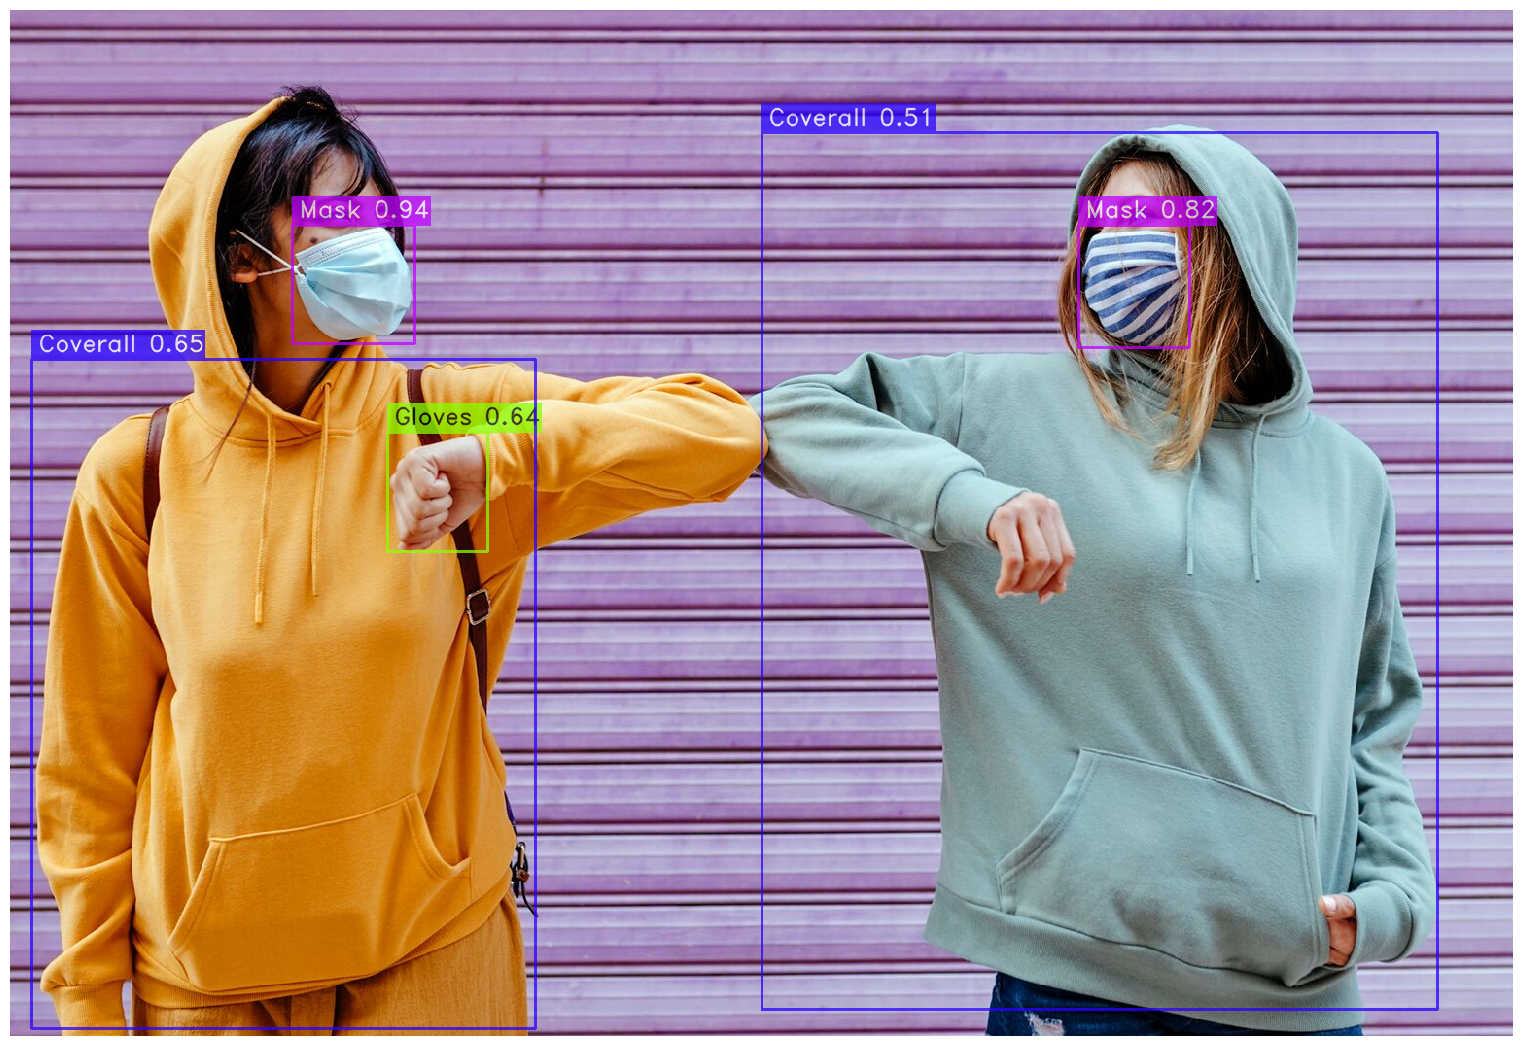

In [12]:
prediction = model.predict(
    "https://dam.northwell.edu/m/1df848c4c688c906/Drupal-NEWS_Wearing-a-mask-is-the-simplest-way-to-combat-COVID-19.jpg", fuse_model=False
)

prediction.show()

# Launch quantization-aware training

Since all local variables are lost, we define again `train_params, train_dataset_params, val_dataset_params, train_dataloader_params, val_dataloader_params`.

Next, we call `modify_params_for_qat`, which will manipulate these configurations according to some best practices for QAT. For example, we turn off augmentations for the trainset. Alll manipulations being done are printed to the screen the for the user's notice.

Finally, after we instantiate our objects with our modified configurations, we call `trainer.qat(model=net, training_params=train_params, train_loader=train_loader, valid_loader=valid_loader, calib_loader=train_loader)`

Under the hood, the following will occur:
- We will use our `calib_loader` which is set to `train_loader` for calibration, gathering statistics that are used to map our network into Int8 range. This part is what we refer to as "Post-training quantization".
- Next, we validate our PTQ model and export it to ONNX format. 
- The exported PTQ model is saved under our checkpoints directory.
- Finally, we perform quantization aware training with our adapted training parameters - since we originally trained for 10 epochs, the general rule of thumb suggests that we quantization-aware train for 10/10=1 epoch. Again, we export the ONNX model to the checkpoints directory.

In [13]:
import os
from super_gradients.common.object_names import Models
from super_gradients.training import models
from super_gradients.training.datasets.detection_datasets.coco_format_detection import COCOFormatDetectionDataset
from super_gradients.training.pre_launch_callbacks import modify_params_for_qat

qat_model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))

qat_train_params, qat_train_dataset_params, qat_valid_dataset_params, qat_train_dataloader_params, qat_val_dataloader_params = modify_params_for_qat(
    train_params, train_dataset_params, valid_dataset_params, train_dataloader_params, val_dataloader_params
)

qat_trainset = COCOFormatDetectionDataset(**qat_train_dataset_params)
qat_valset = COCOFormatDetectionDataset(**qat_valid_dataset_params)

qat_train_loader = DataLoader(qat_trainset, **qat_train_dataloader_params)
qat_valid_loader = DataLoader(qat_valset, **qat_val_dataloader_params)

qat_trainer = Trainer(experiment_name="yolo_nas_s_cppe-5_qat", ckpt_root_dir="experiments")
qat_trainer.qat(model=qat_model, training_params=qat_train_params, train_loader=qat_train_loader, valid_loader=qat_valid_loader, calib_loader=qat_train_loader)

[2023-11-10 11:46:00] INFO - checkpoint_utils.py - Successfully loaded model weights from experiments\yolo_nas_s_cppe-5\RUN_20231110_112751_665019\ckpt_best.pth EMA checkpoint.
[2023-11-10 11:46:01] WARNING - pre_launch_callbacks.py - New number of epochs: 3
[2023-11-10 11:46:01] WARNING - pre_launch_callbacks.py - New learning rate: 5e-06
[2023-11-10 11:46:01] WARNING - pre_launch_callbacks.py - New weight decay: 1.0000000000000002e-06
[2023-11-10 11:46:01] WARNING - pre_launch_callbacks.py - lr_mode will be set to cosine for QAT run instead of CosineLRScheduler with cosine_final_lr_ratio=0.01
[2023-11-10 11:46:01] WARNING - pre_launch_callbacks.py - New lr_warmup_epochs: 1
[2023-11-10 11:46:01] WARNING - pre_launch_callbacks.py - EMA will be disabled for QAT run.
[2023-11-10 11:46:01] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:   0%|          | 

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


Indexing dataset annotations: 100%|██████████| 1000/1000 [00:00<00:00, 3171.58it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


[2023-11-10 11:46:01] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 29/29 [00:00<00:00, 2253.83it/s]
[2023-11-10 11:46:01] INFO - sg_trainer.py - Using default quantization params: {'ptq_only': False, 'selective_quantizer_params': {'calibrator_w': 'max', 'calibrator_i': 'histogram', 'per_channel': True, 'learn_amax': False, 'skip_modules': None}, 'calib_params': {'histogram_calib_method': 'percentile', 'percentile': 99.99, 'num_calib_batches': None, 'verbose': False}}
[2023-11-10 11:46:04] INFO - sg_trainer.py - Calibrating model...
100%|██████████| 63/63 [00:49<00:00,  1.27it/s]
[2023-11-10 11:47:32] INFO - sg_trainer.py - Validating PTQ model...
Testing: 100%|██████████| 1/1 [00:11<00:00, 11.87s/it]
[2023-11-10 11:47:44] INFO - sg_trainer.py - PTQ Model Validation Results
   - Precision@0.50: 0.14197002351284027
   - Recall@0.50: 

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================


C:\Users\ekhve\.conda\envs\sg\lib\site-packages\torch\onnx\symbolic_opset9.py:5589: UserWarning: Exporting aten::index operator of advanced indexing in opset 14 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================


[2023-11-10 11:47:58] INFO - sg_trainer.py - Model exported successfully to experiments\yolo_nas_s_cppe-5_qat\yolo_nas_s_cppe-5_qat_1x3x640x640_ptq.onnx
Model expects input image of shape [1, 3, 640, 640]
Input image dtype is torch.float32
Exported model contains postprocessing (NMS) step with the following parameters:
    num_pre_nms_predictions=1000
    max_predictions_per_image=1000
    nms_threshold=0.65
    confidence_threshold=0.5
    output_predictions_format=batch

Exported model is in ONNX format and can be used with ONNXRuntime
To run inference with ONNXRuntime, please use the following code snippet:

    import onnxruntime
    import numpy as np
    session = onnxruntime.InferenceSession("experiments\yolo_nas_s_cppe-5_qat\yolo_nas_s_cppe-5_qat_1x3x640x640_ptq.onnx", providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
    inputs = [o.name for o in session.get_inputs()]
    outputs = [o.name for o in session.get_outputs()]
    example_input_image = np.zeros((1, 3, 640

The console stream is now moved to experiments\yolo_nas_s_cppe-5_qat\RUN_20231110_114758_052988/console_Nov10_11_47_58.txt


[2023-11-10 11:47:59] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            1000       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         63         (len(train_loader))
    - Gradient updates per epoch:   63         (len(train_loader) / batch_accumulate)

[2023-11-10 11:47:59] INFO - sg_trainer.py - Started training for 3 epochs (0/2)

Validating: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]
[2023-11-10 11:48:33] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5_qat\RUN_20231110_114758_052988\ckpt_best.pth
[2023-11-10 11:4

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7911
│   ├── Ppyoloeloss/loss_iou = 0.4222
│   ├── Ppyoloeloss/loss_dfl = 0.4695
│   └── Ppyoloeloss/loss = 1.6827
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7058
    ├── Ppyoloeloss/loss_iou = 0.3812
    ├── Ppyoloeloss/loss_dfl = 0.4254
    ├── Ppyoloeloss/loss = 1.5124
    ├── Precision@0.50 = 0.1133
    ├── Recall@0.50 = 0.9855
    ├── Map@0.50 = 0.9158
    ├── F1@0.50 = 0.2018
    ├── Ap@0.50_coverall = 0.9255
    ├── Ap@0.50_face_shield = 0.9937
    ├── Ap@0.50_gloves = 0.8783
    ├── Ap@0.50_goggles = 0.8621
    └── Ap@0.50_mask = 0.9195



Validating epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]
[2023-11-10 11:49:04] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5_qat\RUN_20231110_114758_052988\ckpt_best.pth
[2023-11-10 11:49:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9218717813491821


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7853
│   │   ├── Epoch N-1      = 0.7911 (↘ -0.0058)
│   │   └── Best until now = 0.7911 (↘ -0.0058)
│   ├── Ppyoloeloss/loss_iou = 0.4202
│   │   ├── Epoch N-1      = 0.4222 (↘ -0.002)
│   │   └── Best until now = 0.4222 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.4718
│   │   ├── Epoch N-1      = 0.4695 (↗ 0.0024)
│   │   └── Best until now = 0.4695 (↗ 0.0024)
│   └── Ppyoloeloss/loss = 1.6773
│       ├── Epoch N-1      = 1.6827 (↘ -0.0054)
│       └── Best until now = 1.6827 (↘ -0.0054)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7084
    │   ├── Epoch N-1      = 0.7058 (↗ 0.0026)
    │   └── Best until now = 0.7058 (↗ 0.0026)
    ├── Ppyoloeloss/loss_iou = 0.3822
    │   ├── Epoch N-1      = 0.3812 (↗ 0.001)
    │   └── Best until now = 0.3812 (↗ 0.001)
    ├── Ppyoloeloss/loss_dfl = 0.4267
    │   ├── Epoch N-1      = 0.4254 (↗ 0.0013)
    │   └── Best until now = 0.4254 (↗ 0.0013)
    ├── Ppyoloeloss/loss = 1.5173


Validating epoch 2: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]
[2023-11-10 11:49:37] INFO - base_sg_logger.py - Checkpoint saved in experiments\yolo_nas_s_cppe-5_qat\RUN_20231110_114758_052988\ckpt_best.pth
[2023-11-10 11:49:37] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.9220527410507202


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7826
│   │   ├── Epoch N-1      = 0.7853 (↘ -0.0027)
│   │   └── Best until now = 0.7853 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.4192
│   │   ├── Epoch N-1      = 0.4202 (↘ -0.001)
│   │   └── Best until now = 0.4202 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.466
│   │   ├── Epoch N-1      = 0.4718 (↘ -0.0058)
│   │   └── Best until now = 0.4695 (↘ -0.0035)
│   └── Ppyoloeloss/loss = 1.6679
│       ├── Epoch N-1      = 1.6773 (↘ -0.0095)
│       └── Best until now = 1.6773 (↘ -0.0095)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7026
    │   ├── Epoch N-1      = 0.7084 (↘ -0.0058)
    │   └── Best until now = 0.7058 (↘ -0.0032)
    ├── Ppyoloeloss/loss_iou = 0.3802
    │   ├── Epoch N-1      = 0.3822 (↘ -0.002)
    │   └── Best until now = 0.3812 (↘ -0.001)
    ├── Ppyoloeloss/loss_dfl = 0.426
    │   ├── Epoch N-1      = 0.4267 (↘ -0.0007)
    │   └── Best until now = 0.4254 (↗ 0.0006)
    ├── Ppyoloeloss/loss = 1.

[2023-11-10 11:49:38] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
[2023-11-10 11:49:38] WARNING - tensor_quantizer.py - backbone.stem.conv.rbr_reparam._input_quantizer: Overwriting amax.
[2023-11-10 11:49:38] WARNING - tensor_quantizer.py - backbone.stem.conv.rbr_reparam._weight_quantizer: Overwriting amax.
[2023-11-10 11:49:38] WARNING - tensor_quantizer.py - backbone.stage1.downsample.rbr_reparam._input_quantizer: Overwriting amax.
[2023-11-10 11:49:38] WARNING - tensor_quantizer.py - backbone.stage1.downsample.rbr_reparam._weight_quantizer: Overwriting amax.
[2023-11-10 11:49:38] WARNING - tensor_quantizer.py - backbone.stage1.blocks.conv1.conv._input_quantizer: Overwriting amax.
[2023-11-10 11:49:38] WARNING - tensor_quantizer.py - backbone.stage1.blocks.conv1.conv._weight_quantizer: Overwriting amax.
[2023-11-10 11:49:38] WARNING - tensor_quantizer.py - backbone.stage1.blocks.conv2.conv._input_quantizer: Overwriting amax.
[2023-11-10 11:49:38] WARNING -

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================


In [14]:
Trainer(experiment_name="yolo_nas_s_cppe-5-qat-test", ckpt_root_dir="experiments").test(
    model=qat_model,
    test_loader=valid_loader,
    test_metrics_list=[
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=NUM_CLASSES,
            normalize_targets=True,
            include_classwise_ap=True,
            class_names=CLASS_NAMES,
            post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, nms_top_k=1000, max_predictions=300, nms_threshold=0.7),
        )
    ],
)

[2023-11-10 11:49:57] INFO - sg_trainer.py - Exported QAT ONNX to experiments\yolo_nas_s_cppe-5_qat\RUN_20231110_114758_052988\yolo_nas_s_cppe-5_qat_29x3x640x640_qat.onnx
Testing:   0%|          | 0/1 [00:00<?, ?it/s]

{'Precision@0.50': 0.13031794130802155,
 'Recall@0.50': 0.2105293571949005,
 'mAP@0.50': 0.12122990190982819,
 'F1@0.50': 0.12608793377876282,
 'AP@0.50_Coverall': 0.0737781971693039,
 'AP@0.50_Face_Shield': 0.27541518211364746,
 'AP@0.50_Gloves': 0.08909226208925247,
 'AP@0.50_Goggles': 0.08339772373437881,
 'AP@0.50_Mask': 0.08446609973907471}

In [15]:
qat_model._image_processor.processings, qat_model._class_names, qat_model._default_nms_iou, qat_model._default_nms_conf

([<super_gradients.training.processing.processing.ReverseImageChannels at 0x1ea05178730>,
 ['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask'],
 0.65,
 0.5)

In [16]:
model._image_processor.processings, model._class_names, model._default_nms_iou, model._default_nms_conf

([<super_gradients.training.processing.processing.ReverseImageChannels at 0x1e98c4a39d0>,
 ['Coverall', 'Face_Shield', 'Gloves', 'Goggles', 'Mask'],
 0.65,
 0.5)

Testing: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


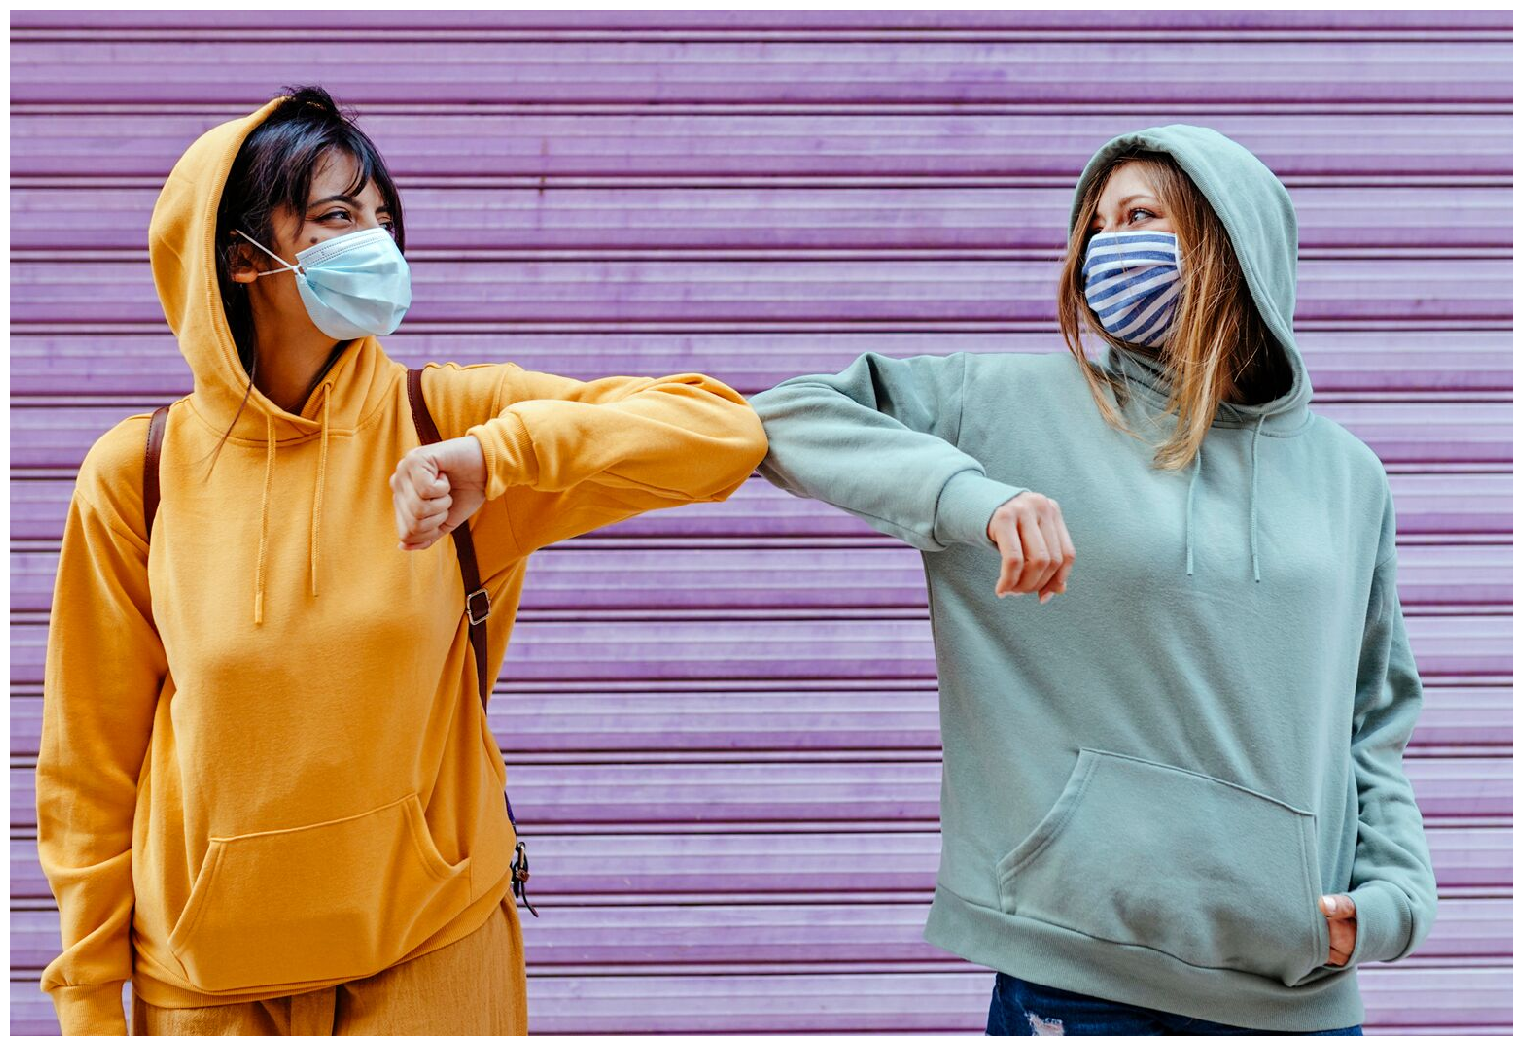

In [17]:
prediction = qat_model.predict(
    "https://dam.northwell.edu/m/1df848c4c688c906/Drupal-NEWS_Wearing-a-mask-is-the-simplest-way-to-combat-COVID-19.jpg", fuse_model=False
)

prediction.show()

# Summary

And there we have it! Our PTQ and QAT checkpoints have been exported to our checkpoints directory under
/content/sg_checkpoints_dir/yolo_nas_s_soccer_players/yolo_nas_s_soccer_players_32x3x640x640_ptq.onnx
and
/content/sg_checkpoints_dir/yolo_nas_s_soccer_players/yolo_nas_s_soccer_players_32x3x640x640_qat.onnx".

If we plug them into [netron](https://netron.app), we can see that new blocks that were not a part of the original network were introduced: the **Quantize/Dequantize** layers -

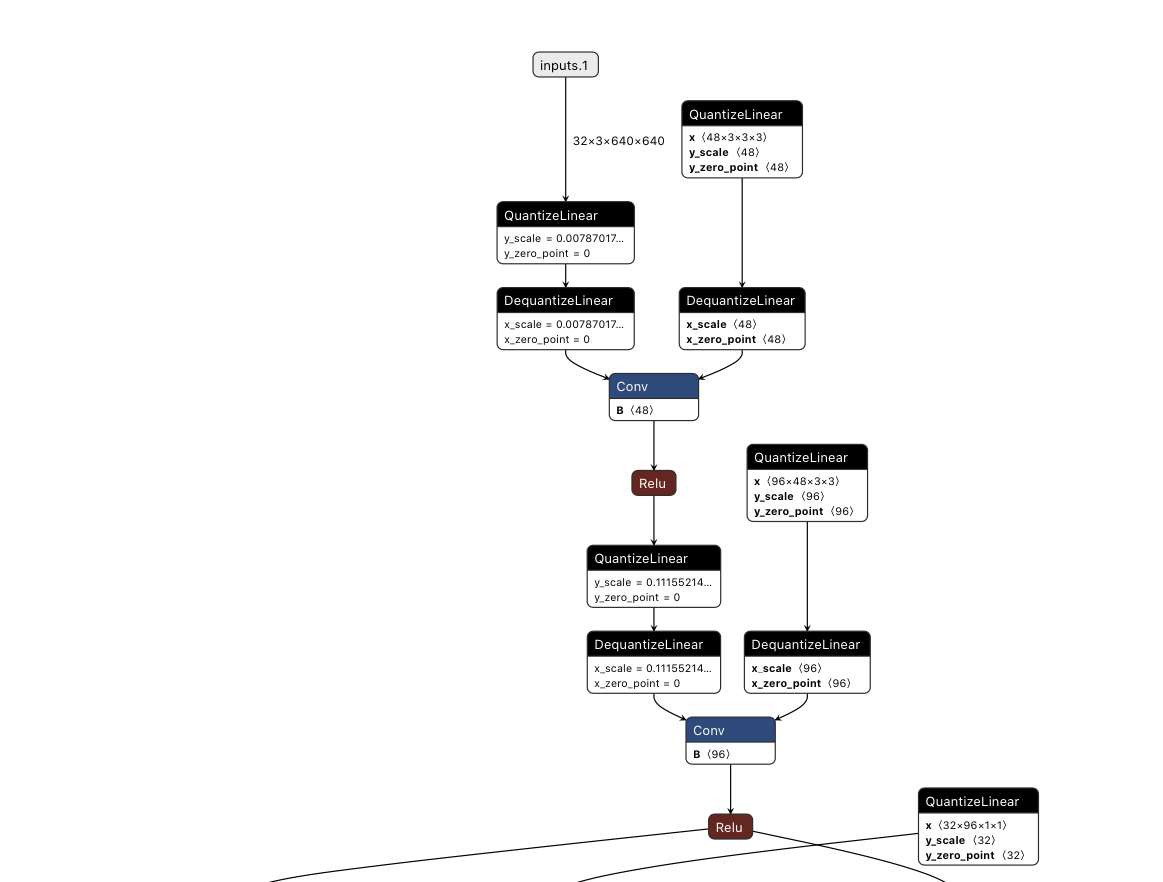

This is expected and a good way to verify that our model is ready to be converted to Int8 using Nvidia's [TesnorRT](https://docs.nvidia.com/deeplearning/tensorrt/quick-start-guide/index.html#deploy-engine):
 We can now use these ONNX files to deploy our newly trained YoloNAS models to production. When building the TRT engine it is important specify that we convert to Int8 (the fake quantized layers in our models will be adapted accordingly), this can be done by running:
`trtexec --fp16 --int8 --onnx=your_yolonas_qat_model.onnx`.

For more information on how to properly export and benchmark YoloNAS, click [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/BenchmarkingYoloNAS.md).